# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import time
import re
import string
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import KNNImputer
from wordcloud import WordCloud
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

X_train = pd.read_csv('/content/drive/My Drive/BT4012/X_train.csv')
X_test = pd.read_csv('/content/drive/My Drive/BT4012/X_test.csv')
y_train = pd.read_csv('/content/drive/My Drive/BT4012/y_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/BT4012/y_test.csv')

Mounted at /content/drive


# Data Preprocessing

## Text Processing

In [3]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = [w for w in text if w not in stop_words]
    return words


def lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemmatized

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the tokenizer
# this tokenizer splits the text into words while ignoring punctuation
tokenizer = RegexpTokenizer(r'\w+')

# Apply the text processing functions
def process_text(text_series):
    # Cleaning
    cleaned = text_series.apply(clean_text)
    # Tokenization
    tokenized = cleaned.apply(tokenizer.tokenize)
    # Remove Stopwords
    stopped = tokenized.apply(remove_stopwords)
    # Lemmatization
    lemmatized = stopped.apply(lemmatizer)
    # Combine into single string
    processed = lemmatized.apply(lambda x: " ".join(x))
    return processed


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
# Add processed text back to the training and test dataframes
X_train['processed_text'] = process_text(X_train['combined_text'])
X_test['processed_text'] = process_text(X_test['combined_text'])

# Display the head of the processed training data
X_train.head()

,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,salary_lower_bound,salary_upper_bound,combined_text,processed_text
0,US,0,1,0,Other,Not Applicable,Unspecified,0,0,Project Manager Project Manager will functio...,project manager project manager function overa...
1,US,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,0,0,Software Developer a.k.a CS Macgyver Urban Rob...,software developer aka c macgyver urban roboti...
2,GB,0,1,1,Full-time,Entry level,Unspecified,0,0,Assistant Managers / Supervisors Take Out Bran...,assistant manager supervisor take brand food f...
3,RU,0,1,0,Full-time,Mid-Senior level,Master's Degree,0,0,Lead Recruiter УУРРАА - технологическая компан...,lead recruiter уурраа технологическая компания...
4,US,0,0,1,Full-time,Mid-Senior level,Bachelor's Degree,85000,120000,. Net Developers In this role the Software D...,net developer role software developer analyst ...


## Encoding Location column using Frequency Encoding

In [5]:
# Perform frequency encoding on location
# Calculate frequency encoding based on the training set
location_freq = X_train['location'].value_counts() / len(X_train)

# Apply this encoding to both the training and test sets
X_train['location_encoded'] = X_train['location'].map(location_freq).fillna(0)
X_test['location_encoded'] = X_test['location'].map(location_freq).fillna(0)  # Handle locations not seen in training


## Encoding Categorical Data using Ordinal Encoding

In [6]:
employment_type_categories = ['Other', 'Temporary', 'Part-time', 'Contract', 'Full-time']
required_experience_categories = ['Not Applicable', 'Internship', 'Entry level',
                           'Associate', 'Mid-Senior level', 'Director',
                           'Executive']
required_education_categories = ['Unspecified', 'Some High School Coursework', 'High School or equivalent', 'Some College Coursework Completed', 'Vocational - HS Diploma', "Bachelor's Degree", 'Vocational', 'Certification', 'Associate Degree', "Master's Degree", 'Vocational - Degree', 'Professional', 'Doctorate']


In [7]:
encoder = OrdinalEncoder(categories=[employment_type_categories])

X_train['employment_type_categories'] = encoder.fit_transform(X_train[['employment_type']])
X_test['employment_type_categories'] = encoder.transform(X_test[['employment_type']])

In [8]:
encoder = OrdinalEncoder(categories=[required_experience_categories])

X_train['required_experience_categories'] = encoder.fit_transform(X_train[['required_experience']])
X_test['required_experience_categories'] = encoder.transform(X_test[['required_experience']])

In [9]:
encoder = OrdinalEncoder(categories=[required_education_categories])

X_train['required_education_categories'] = encoder.fit_transform(X_train[['required_education']])
X_test['required_education_categories'] = encoder.transform(X_test[['required_education']])

In [10]:
# List of columns to drop
columns_to_drop = ['combined_text', 'location', 'employment_type', 'required_experience', 'required_education']

# Drop these columns from the training and test sets
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

## Handling Missing Salary Data using KNN-Imputation
#### Note: This step is done after splitting to prevent data leakage

In [11]:
X_train[['salary_lower_bound', 'salary_upper_bound']] = X_train[['salary_lower_bound', 'salary_upper_bound']].replace(0, np.nan)
X_test[['salary_lower_bound', 'salary_upper_bound']] = X_test[['salary_lower_bound', 'salary_upper_bound']].replace(0, np.nan)

In [12]:
knn = KNNImputer(n_neighbors=5, weights='distance')
X_train[['salary_lower_bound', 'salary_upper_bound']] = knn.fit_transform(X_train[['salary_lower_bound', 'salary_upper_bound']])

X_test[['salary_lower_bound', 'salary_upper_bound']] = knn.transform(X_test[['salary_lower_bound', 'salary_upper_bound']])

## Process Numerical features

In [13]:
numerical_features = ['telecommuting', 'has_company_logo', 'has_questions', 'location_encoded', 'salary_lower_bound', 'salary_upper_bound']

# Scale non-binary data
scaler = StandardScaler()
X_train[['salary_lower_bound', 'salary_upper_bound']]  = scaler.fit_transform(X_train[['salary_lower_bound', 'salary_upper_bound']] )
X_test[['salary_lower_bound', 'salary_upper_bound']] = scaler.transform(X_test[['salary_lower_bound', 'salary_upper_bound']] )

# Separate the scaled numerical features
scaled_numerical_features = X_train[numerical_features]


In [ ]:
# numerical_features = ['telecommuting', 'has_company_logo', 'has_questions', 'location_encoded', 'salary_lower_bound', 'salary_upper_bound']

# scaler = StandardScaler()
# X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# X_test[numerical_features] = scaler.transform(X_test[numerical_features])

## Vectorise processed text

In [ ]:
# # Initialize the TF-IDF Vectorizer with default parameters
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the TF-IDF vectorizer on the training set
tfidf_features = tfidf_vectorizer.fit_transform(X_train['processed_text'])

# Combine the numerical features and the TF-IDF features
X_train_combined = hstack([scaled_numerical_features, tfidf_features])

# Do the same for X_test
scaled_numerical_features_test = X_test[numerical_features]
tfidf_features_test = tfidf_vectorizer.transform(X_test['processed_text'])
X_test_combined = hstack([scaled_numerical_features_test, tfidf_features_test])


# Run Models

## Random Forest

<ipython-input-14-069cdd4c5561>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomforest.fit(X_train_combined, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defin

Random Forest Model Evaluation on Training Set:


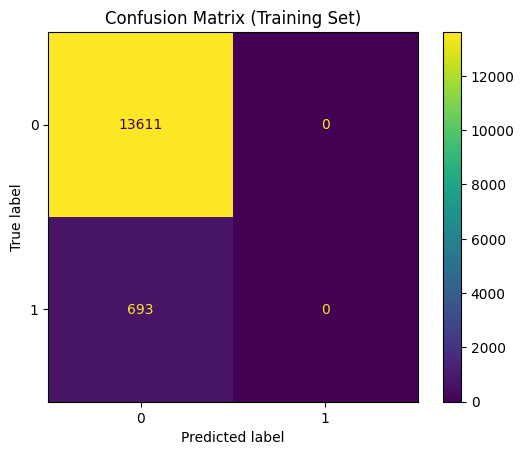


Metrics for Training Set:
Accuracy: 0.9516
AUC: 0.9744

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     13611
           1       0.00      0.00      0.00       693

    accuracy                           0.95     14304
   macro avg       0.48      0.50      0.49     14304
weighted avg       0.91      0.95      0.93     14304

Random Forest Model Evaluation on Test Set:


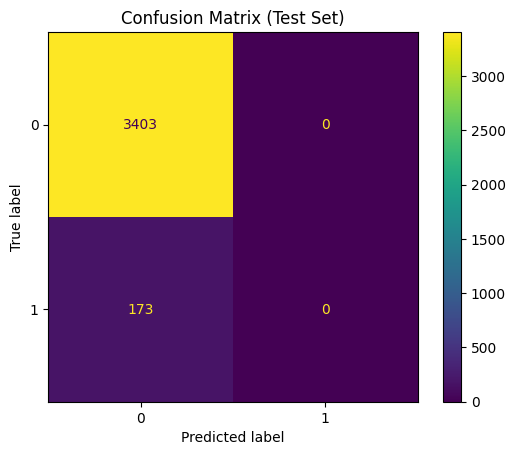

Metrics for Test Set:
Accuracy: 0.9516
AUC: 0.9640

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3403
           1       0.00      0.00      0.00       173

    accuracy                           0.95      3576
   macro avg       0.48      0.50      0.49      3576
weighted avg       0.91      0.95      0.93      3576



In [14]:
# Initialize the Random Forest model
randomforest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=6)

# Fit the model on the training data
randomforest.fit(X_train_combined, y_train)

# Predict on the training data
y_pred_train = randomforest.predict(X_train_combined)
# Get the probability scores for the positive class
y_prob_train = randomforest.predict_proba(X_train_combined)[:, 1]

# Predict on the test data
y_pred_test = randomforest.predict(X_test_combined)
# Get the probability scores for the positive class
y_prob_test = randomforest.predict_proba(X_test_combined)[:, 1]


# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_prob_test)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
classification_rep_train = classification_report(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, y_prob_train)

# Plot the confusion matrix for the training set
print("Random Forest Model Evaluation on Training Set:")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Print metrics for the training set
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print("\nClassification Report:")
print(classification_rep_train)

# Plot the confusion matrix for the test set
print("Random Forest Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Print metrics for the test set
print("Metrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print("\nClassification Report:")
print(classification_rep_test)



## Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Model Evaluation on Training Set:


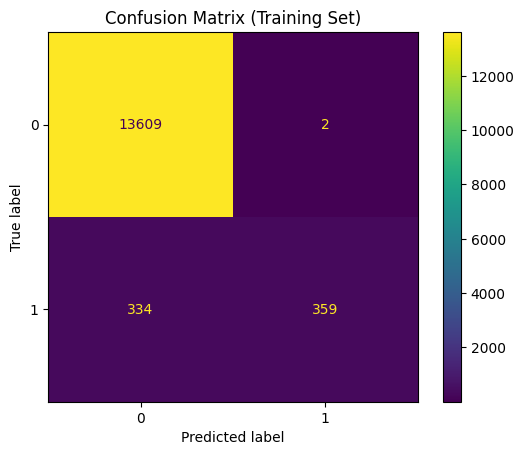


Metrics for Training Set:
Accuracy: 0.9765
AUC: 0.9934

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13611
           1       0.99      0.52      0.68       693

    accuracy                           0.98     14304
   macro avg       0.99      0.76      0.83     14304
weighted avg       0.98      0.98      0.97     14304

Logistic Regression Model Evaluation on Test Set:


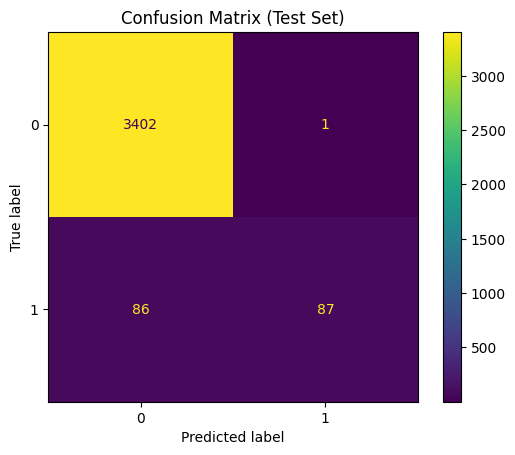

Metrics for Test Set:
Accuracy: 0.9757
AUC: 0.9853

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.50      0.67       173

    accuracy                           0.98      3576
   macro avg       0.98      0.75      0.83      3576
weighted avg       0.98      0.98      0.97      3576



In [15]:
# Initialize the logistic regression model
logreg = LogisticRegression(random_state=4012)

# Fit the model on the training data
logreg.fit(X_train_combined, y_train)

# Predict probabilities on the test data
y_prob_train = logreg.predict_proba(X_train_combined)[:, 1]
# Convert probabilities to binary predictions
y_pred_train = logreg.predict(X_train_combined)

# Predict probabilities on the test data
y_prob_test = logreg.predict_proba(X_test_combined)[:, 1]
# Convert probabilities to binary predictions
y_pred_test = logreg.predict(X_test_combined)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_prob_test)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
classification_rep_train = classification_report(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, y_prob_train)

# Plot the confusion matrix for the training set
print("Logistic Regression Model Evaluation on Training Set:")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Print metrics for the training set
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print("\nClassification Report:")
print(classification_rep_train)

# Plot the confusion matrix for the test set
print("Logistic Regression Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Print metrics for the test set
print("Metrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print("\nClassification Report:")
print(classification_rep_test)

## Support Vector Classification

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random Forest Model Evaluation on Training Set:


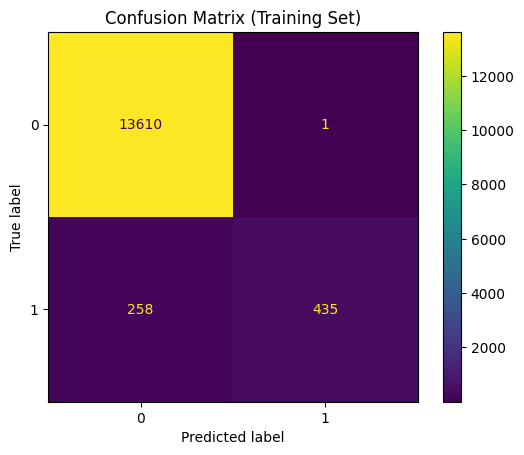


Metrics for Training Set:
Accuracy: 0.9819
AUC: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13611
           1       1.00      0.63      0.77       693

    accuracy                           0.98     14304
   macro avg       0.99      0.81      0.88     14304
weighted avg       0.98      0.98      0.98     14304

Random Forest Model Evaluation on Test Set:


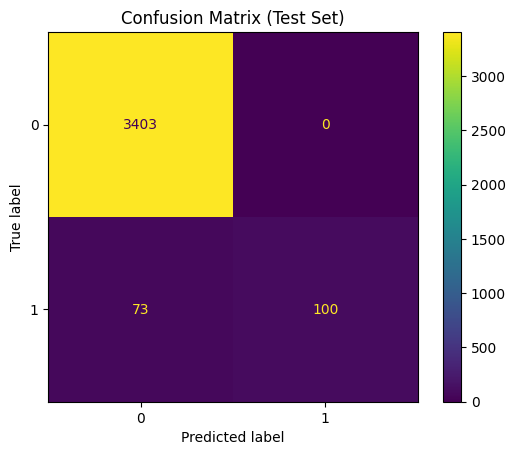

Metrics for Test Set:
Accuracy: 0.9796
AUC: 0.9935

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.58      0.73       173

    accuracy                           0.98      3576
   macro avg       0.99      0.79      0.86      3576
weighted avg       0.98      0.98      0.98      3576



In [17]:
start_time = time.time()
# Initialize the SVM model
svm_model = SVC(random_state=4012, probability=True)

# Fit the SVM model on the training data
svm_model.fit(X_train_combined, y_train)

# Predict probabilities on the test data
y_prob_train_svm = svm_model.predict_proba(X_train_combined)[:, 1]
# Convert probabilities to binary predictions
y_pred_train_svm = svm_model.predict(X_train_combined)

# Predict probabilities on the test data
y_prob_test_svm = svm_model.predict_proba(X_test_combined)[:, 1]
# Convert probabilities to binary predictions
y_pred_test_svm = svm_model.predict(X_test_combined)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test_svm)
conf_matrix_test = confusion_matrix(y_test, y_pred_test_svm)
classification_rep_test = classification_report(y_test, y_pred_test_svm)
auc_test = roc_auc_score(y_test, y_prob_test_svm)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train_svm)
conf_matrix_train = confusion_matrix(y_train, y_pred_train_svm)
classification_rep_train = classification_report(y_train, y_pred_train_svm)
auc_train = roc_auc_score(y_train, y_prob_train_svm)

# Plot the confusion matrix for the training set
print("Random Forest Model Evaluation on Training Set:")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Print metrics for the training set
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print("\nClassification Report:")
print(classification_rep_train)

# Plot the confusion matrix for the test set
print("Random Forest Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Print metrics for the test set
print("Metrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print("\nClassification Report:")
print(classification_rep_test)

### Perform Cross-Validation to reduce Runtime


Cross Validation is carried out the training data to determine the optimal hyperparameters used for the SVC model. We used ```GridSearchCV()``` which involves a k-fold approach. ```Stratified k-Fold``` is used as our dataset is imbalanced. It ensures that each fold has a similar distribution of the ```Fraudlent``` column. By splitting the training data into k subsets, all k-1 subsets are iteratively treated as training data and evaluated on the remaining subsets. This gives us recommendations of the optimal hyperparameters to use in our model.

However, it is pertinent to note that this process is expensive. Due to the large time complexity involved, the process took almost two hours to complete. Parameter values tested in the cross-validation test were as follows: {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}. The optimal values recommended are as follows: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}.


In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Set up k-fold cross-validation
k_fold_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=4012)

# Initialize the SVM model
svm_test = SVC(random_state=4012, probability=True)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_test, param_grid=param_grid, cv=k_fold_test, scoring='f1', n_jobs=-1)

# Perform hyperparameter tuning with cross-validation
grid_search.fit(X_train_combined, y_train)

# Print the best hyperparameters and corresponding F1-score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Get the best model from the hyperparameter tuning
best_svm_model = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred_svm_test = best_svm_model.predict(X_test_combined)

# Evaluate the final model performance on the test set using F1-score
final_f1_score = f1_score(y_test, y_pred_svm_test)
print("\nFinal F1-score on Test Set:", final_f1_score)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1-score: 0.8346848046827555

Final F1-score on Test Set: 0.8717948717948718


Running the improved model on the Test set, it can be observed that the f1-score has improved in detecting fradulent cases.

Cross-validated SVM Model Evaluation on Test Set:


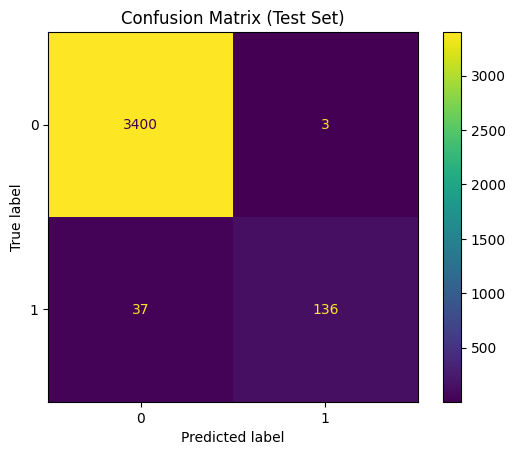

Metrics for Test Set:
Accuracy: 0.9888
AUC: 0.9935

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.98      0.79      0.87       173

    accuracy                           0.99      3576
   macro avg       0.98      0.89      0.93      3576
weighted avg       0.99      0.99      0.99      3576



In [24]:
# Predict on the test data using the best model
y_pred_svm_test = best_svm_model.predict(X_test_combined)
# Predict probabilities on the test data
y_prob_svm_test = svm_model.predict_proba(X_test_combined)[:, 1]

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_svm_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_svm_test)
classification_rep_test = classification_report(y_test, y_pred_svm_test)
auc_test = roc_auc_score(y_test, y_prob_svm_test)

# Plot the confusion matrix for the test set
print("Cross-validated SVM Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Print metrics for the test set
print("Metrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print("\nClassification Report:")
print(classification_rep_test)

## XGBoost

XGBoost Model Evaluation on Training Set:


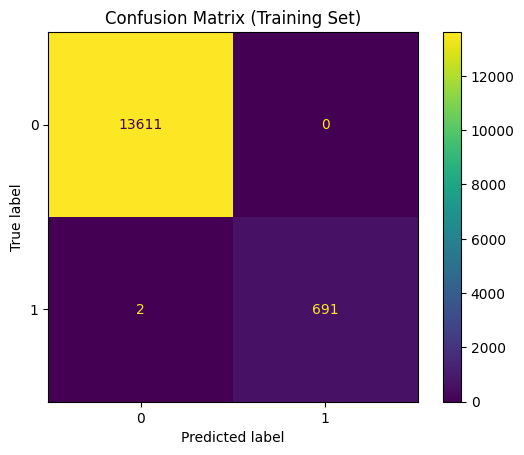


Metrics for Training Set:
Accuracy: 0.9999
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13611
           1       1.00      1.00      1.00       693

    accuracy                           1.00     14304
   macro avg       1.00      1.00      1.00     14304
weighted avg       1.00      1.00      1.00     14304

XGBoost Model Evaluation on Test Set:


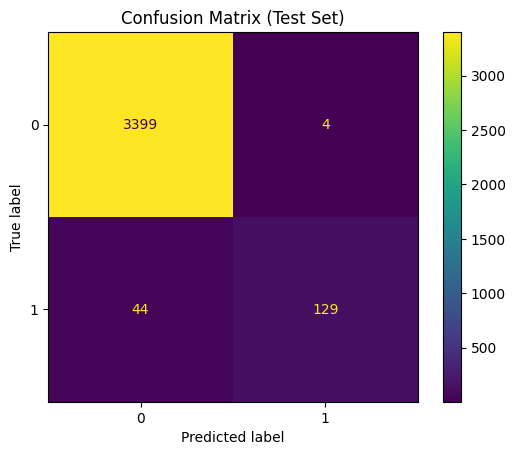

Metrics for Test Set:
Accuracy: 0.9866
AUC: 0.9940

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.97      0.75      0.84       173

    accuracy                           0.99      3576
   macro avg       0.98      0.87      0.92      3576
weighted avg       0.99      0.99      0.99      3576



In [20]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=4012)
xgb_model.fit(X_train_combined, y_train)

# Predict on the train data
y_pred_train_xgb = xgb_model.predict(X_train_combined)
# Predict probabilities on the train data
y_prob_train_xgb = xgb_model.predict_proba(X_train_combined)[:, 1]

# Predict on the test data
y_pred_test_xgb = xgb_model.predict(X_test_combined)
# Predict probabilities on the test data
y_prob_test_xgb = xgb_model.predict_proba(X_test_combined)[:, 1]

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test_xgb)
conf_matrix_test = confusion_matrix(y_test, y_pred_test_xgb)
classification_rep_test = classification_report(y_test, y_pred_test_xgb)
auc_test = roc_auc_score(y_test, y_prob_test_xgb)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train_xgb)
conf_matrix_train = confusion_matrix(y_train, y_pred_train_xgb)
classification_rep_train = classification_report(y_train, y_pred_train_xgb)
auc_train = roc_auc_score(y_train, y_prob_train_xgb)

# Plot the confusion matrix for the training set
print("XGBoost Model Evaluation on Training Set:")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Print metrics for the training set
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print("\nClassification Report:")
print(classification_rep_train)

# Plot the confusion matrix for the test set
print("XGBoost Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Print metrics for the test set
print("Metrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print("\nClassification Report:")
print(classification_rep_test)

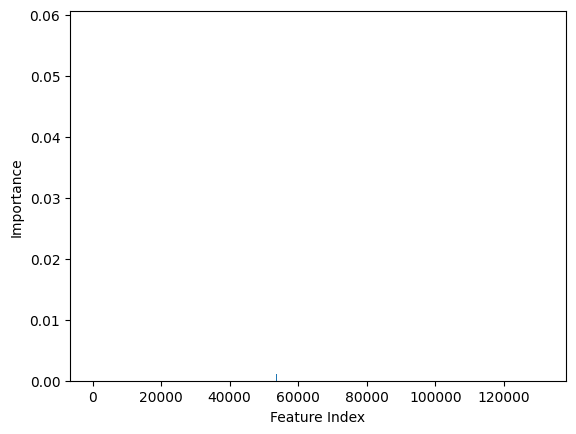

In [21]:
from sklearn.feature_selection import SelectFromModel

# Initialize the XGBoost model with the desired parameters
xgb_model = xgb.XGBClassifier(random_state=4012)
xgb_model.fit(X_train_combined, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_

plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Initialize the XGBoost model with the desired parameters
xgb_model = xgb.XGBClassifier(random_state=4012)
xgb_model.fit(X_train_combined, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Use feature importances to select important features
sfm = SelectFromModel(xgb_model, threshold=0.0001)  # You can adjust the threshold
sfm.fit(X_train_combined, y_train)


# Transform the datasets based on selected features
X_train_selected = sfm.transform(X_train_combined)
X_test_selected = sfm.transform(X_test_combined)

# Train the XGBoost model on the selected features
xgb_model.fit(X_train_selected, y_train)

# Perform predictions and evaluations as before
y_pred_train_xgb = xgb_model.predict(X_train_selected)
y_prob_train_xgb = xgb_model.predict_proba(X_train_selected)[:, 1]

y_pred_test_xgb = xgb_model.predict(X_test_selected)
y_prob_test_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test_xgb)
conf_matrix_test = confusion_matrix(y_test, y_pred_test_xgb)
classification_rep_test = classification_report(y_test, y_pred_test_xgb)
auc_test = roc_auc_score(y_test, y_prob_test_xgb)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train_xgb)
conf_matrix_train = confusion_matrix(y_train, y_pred_train_xgb)
classification_rep_train = classification_report(y_train, y_pred_train_xgb)
auc_train = roc_auc_score(y_train, y_prob_train_xgb)

# Plot the confusion matrix for the training set
print("XGBoost Model Evaluation on Training Set (with Feature Selection):")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Print metrics for the training set
print("\nMetrics for Training Set (with Feature Selection):")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print("\nClassification Report:")
print(classification_rep_train)

# Plot the confusion matrix for the test set
print("XGBoost Model Evaluation on Test Set (with Feature Selection):")
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Print metrics for the test set
print("Metrics for Test Set (with Feature Selection):")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print("\nClassification Report:")
print(classification_rep_test)


AttributeError: ignored